# Fairness analysis of risk scores

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from holisticai.bias.plots import correlation_matrix_plot, abroca_plot
from holisticai.bias.metrics import classification_bias_metrics, abroca
from holisticai.efficacy.metrics import classification_efficacy_metrics

from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio, demographic_parity_difference, demographic_parity_ratio

In [107]:
os.chdir('C:\\Users\\Zezulka\\Documents\\01_PhD\\030-Projects\\2023-01_ALMP_LTU\\')

data_path_female = 'data\\1203_ALMP_Sample_effects_risk_fairFemale.csv'
data_path_swiss = 'data\\1203_ALMP_Sample_IATEs_fair_risk.csv'
df = pd.read_csv(data_path_female)

df.head()

,Unnamed: 0,X,ID,age,canton_french,canton_german,canton_italian,canton_moth_tongue,city,city_big,...,em_computer,em_language,em_job_search,em_employment,em_personality,risk_score_logistic,risk_score_log,risk_score_sp,risk_score_eo,risk_score_if
0,1,7,61573,37,0,1,0,0,1,0,...,0.011855,0.052315,0.162117,0.004732,0.015453,0.368516,0.414661,0.387534,0.381452,0.384184
1,2,8,49765,27,0,1,0,0,1,0,...,0.009024,0.045423,0.193998,0.014603,0.009894,0.409957,0.461331,0.453227,0.457943,0.455823
2,3,11,22825,28,0,1,0,0,2,0,...,0.013906,0.016076,0.234077,0.005441,0.014845,0.378165,0.398117,0.387785,0.392167,0.390198
3,4,12,15708,52,0,1,0,0,1,0,...,0.016750,0.039539,0.158061,0.009151,0.009460,0.848244,0.721583,0.796351,0.792355,0.794152
4,5,13,89600,47,0,1,0,0,1,0,...,0.018052,0.020780,0.193289,0.007141,0.011978,0.509973,0.466319,0.452881,0.446776,0.449519


In [156]:
# groups 
female = np.squeeze((df['female'] == 1).values)
male = np.squeeze((df['female'] == 0).values)

non_citizen = np.squeeze((df['swiss'] == 0).values)
citizen = np.squeeze((df['swiss'] == 1).values)

# threshold
t = 0.5

# y_true
y_true = 1 - df['y_exit12']

In [166]:
# classification quality
df_classification_old = classification_efficacy_metrics(y_true, (df['risk_score_logistic'] <= t).astype(int))
df_classification = classification_efficacy_metrics(y_true, (df['risk_score_log'] <= t).astype(int))
df_classification_sp = classification_efficacy_metrics(y_true, (df['risk_score_sp'] <= t).astype(int))
df_classification_eo = classification_efficacy_metrics(y_true, (df['risk_score_eo'] <= t).astype(int))
df_classification_if = classification_efficacy_metrics(y_true, (df['risk_score_if'] <= t).astype(int))

df_class_naive = classification_efficacy_metrics(1- y_test, 1-y_pred_logreg)

classification = pd.concat([df_classification_old, df_classification, df_classification_sp, df_classification_eo, df_classification_if,df_class_naive], axis=1).iloc[:, [0,2,4,6,8,10,1]]
classification.columns = ['Baseline old','Baseline','SP','EO','IF','Naive Log','Reference']

In [167]:
# fairness analysis: group_a = female
df_baseline_old = classification_bias_metrics(female, 
                                              male, 
                                              (df['risk_score_logistic'] <= t).astype(int),
                                              y_true)
df_baseline = classification_bias_metrics(female, 
                                          male, 
                                          (df['risk_score_log'] <= t).astype(int),
                                          y_true)
df_sp = classification_bias_metrics(female, 
                                    male, 
                                    (df['risk_score_sp'] <= t).astype(int),
                                    y_true)
df_eo = classification_bias_metrics(female, 
                                    male, 
                                    (df['risk_score_eo'] <= t).astype(int),
                                    y_true)
df_if = classification_bias_metrics(female, 
                                    male, 
                                    (df['risk_score_eo'] <= t).astype(int),
                                    y_true)

df_naive_log = classification_bias_metrics(female_naive, 
                                           male_naive, 
                                           1- y_pred_logreg,
                                           1- y_test)

result = pd.concat([df_baseline_old, df_baseline, df_sp, df_eo, df_if,df_naive_log], axis=1).iloc[:, [0,2,4,6,8,10,1]]
result.columns = ['Baseline old','Baseline','SP','EO','IF','Naive Log','Reference']

# Compare results

In [168]:
classification

,Baseline old,Baseline,SP,EO,IF,Naive Log,Reference
Metric,,,,,,,
Accuracy,0.639747,0.637155,0.639125,0.638192,0.638607,0.643746,1
Balanced Accuracy,0.612204,0.603922,0.610432,0.609428,0.609820,0.617957,1
Precision,0.654972,0.645604,0.652935,0.652206,0.652455,0.664297,1
Recall,0.792446,0.821403,0.798201,0.797662,0.798201,0.779499,1
F1-Score,0.717181,0.722970,0.718297,0.717638,0.718007,0.717302,1


In [169]:
result

,Baseline old,Baseline,SP,EO,IF,Naive Log,Reference
Metric,,,,,,,
Statistical Parity,-0.099079,-0.115678,-0.023836,-0.004642,-0.004642,-0.080898,0
Disparate Impact,0.866330,0.852551,0.966671,0.993435,0.993435,0.886867,1
Four Fifths Rule,0.866330,0.852551,0.966671,0.993435,0.993435,0.886867,1
Cohen D,-0.216923,-0.263833,-0.052267,-0.010178,-0.010178,-0.174120,0
2SD Rule,-10.520525,-12.760572,-2.548723,-0.496471,-0.496471,-4.618629,0
Equality of Opportunity Difference,-0.061030,-0.063362,0.001539,0.022301,0.022301,-0.048374,0
False Positive Rate Difference,-0.134774,-0.171715,-0.042607,-0.025617,-0.025617,-0.113073,0
Average Odds Difference,-0.097902,-0.117539,-0.020534,-0.001658,-0.001658,-0.080724,0
Accuracy Difference,0.011851,0.024064,0.007923,0.012538,0.012538,0.012854,0


# Baseline logistic regression

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [127]:
# Var list including all dummy categories.
risk_var_list = ["age","canton_moth_tongue","city_big","city_medium","city_no",
                   "emp_share_last_2yrs","emp_spells_5yrs",
                   "female","foreigner_b","foreigner_c","gdp_pc","married","other_mother_tongue","past_income",
                   "prev_job_manager","prev_job_sec_mis","prev_job_sec1","prev_job_sec2",
                   "prev_job_sec3","prev_job_self","prev_job_skilled","prev_job_unskilled",
                   "qual_semiskilled","qual_degree","qual_unskilled","qual_wo_degree",
                   "swiss","ue_spells_last_2yrs","unemp_rate"
                ]

In [132]:
# prepare data
y = df['y_exit12']
X = df[risk_var_list]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

female_naive = np.squeeze((X_test['female'] == 1).values)
male_naive = np.squeeze((X_test['female'] == 0).values)

In [133]:
# Create a logistic regression model
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)
y_score_logreg = y_proba_logreg[:,1]

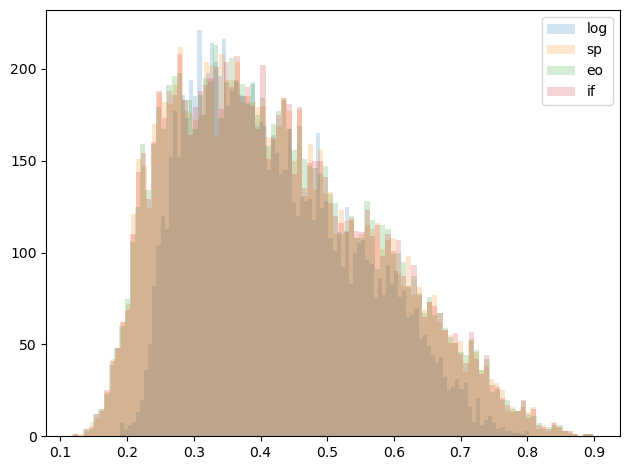

In [155]:
#plt.hist(y_score_logreg, bins=100, alpha=0.5)
plt.hist(df['risk_score_log'], bins=100, alpha=0.2, label='log')
plt.hist(df['risk_score_sp'], bins=100, alpha=0.2, label='sp')
plt.hist(df['risk_score_eo'], bins=100, alpha=0.2, label='eo')
plt.hist(df['risk_score_if'], bins=100, alpha=0.2, label='if')
plt.legend()
plt.tight_layout()
plt.show()